# **Attention Map**
This notebook refers to: https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb

# **Configurations**

In [1]:
# @title Colab Settings

# @markdown Whether to clone from our private repo, or manually put aml/ in our zip into /content/
colab_clone_repo = True     #@param {type:'boolean'}

# **Prepare The Execution Environment**

In [2]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if colab_clone_repo and not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    if colab_clone_repo:
        %cd /content/applied-ml/
    else:
        %cd /content/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install ftfy
    !pip install captum

/content/applied-ml


In [3]:
if not os.path.exists('./CLIP/'):
    print('Getting custom CLIP with hooks')
    !git clone https://github.com/hila-chefer/Transformer-MM-Explainability
    !mv ./Transformer-MM-Explainability/CLIP/ ./
    !rm -rf ./Transformer-MM-Explainability/

In [4]:
import aml.datasets
import numpy as np
import torch
import CLIP.clip
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = CLIP.clip.load('ViT-B/16', device=device, jit=False)

# Attention Map Functions
Note: These are directly copied from the original notebook

In [6]:
def interpret(image, texts, model, device, start_layer, start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [7]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [8]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    print(text_scores)
    text_tokens=_tokenizer.encode(text)
    text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)

# **Analyze Attention Map**

In [9]:
#@title Number Of Attention Layers To Consider
#@markdown Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@markdown Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

tensor([0.0549, 0.2273, 0.0096, 0.0000, 0.0009, 0.0023, 0.0549, 0.0289, 0.2195,
        0.3293, 0.0000, 0.0195, 0.0000, 0.0466, 0.0063], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a airplane looks like a long tube with two wings sticking out the sides .


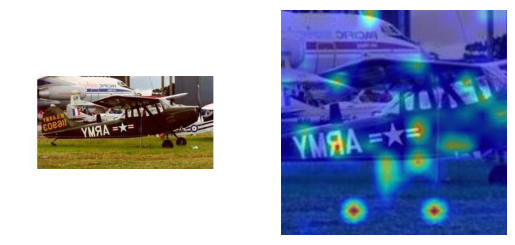

In [20]:
# @title Choose Image And Visualize Attention Map

# @markdown Test on which dataset
test_dataset_name = 'caltech'   #@param ['airplane', 'caltech', 'dtd', 'flower', 'food', 'pets', 'ucf']
# test_dataset_name = 'airplane'
# test_dataset_name = 'caltech'
# test_dataset_name = 'dtd'
# test_dataset_name = 'flower'
# test_dataset_name = 'food'
# test_dataset_name = 'pets'
# test_dataset_name = 'ucf'

match test_dataset_name:
    case 'airplane':
        dataset_test = aml.datasets.FGVCAircraft(datasets_path, split='test')
    case 'caltech':
        dataset_test = aml.datasets.Caltech101(datasets_path, split='test')
    case 'dtd':
        dataset_test = aml.datasets.DTD(datasets_path, split='test')
    case 'flower':
        dataset_test = aml.datasets.Flowers102(datasets_path, split='test')
    case 'food':
        dataset_test = aml.datasets.Food101(datasets_path, split='test')
    case 'pets':
        dataset_test = aml.datasets.OxfordIIITPet(datasets_path, split='test')
    case 'ucf':
        dataset_test = aml.datasets.UCF101(datasets_path, split='test')

# @markdown Which image in the dataset
vis_img_idx = 634   #@param {type:'integer'}

# @markdown What text to test
vis_text = 'A airplane looks like a long tube with two wings sticking out the sides.'  #@param {type:'string'}

org_img, label_id = dataset_test[vis_img_idx]
img = preprocess(org_img).unsqueeze(0).to(device)
texts = [vis_text]
text = CLIP.clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device, start_layer=start_layer, start_layer_text=start_layer_text)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=org_img)
  plt.show()